# Machine Learning Pipeline - Scoring New Data

Let's imagine that a colleague from the business department comes and asks us to score the data from last months customers. They want to be sure that our model is working appropriately in the most recent data that the organization has.

**How would you go about to score the new data?** Try to give it a go. There is more than 1 way of doing it.

Below we present one potential solution.

What could we have done better?

In [5]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
# to save the model
import joblib

In [6]:
# load the unseen / new dataset
data = pd.read_csv('test.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
#Loading features of the model

features = pd.read_csv('selected_features.csv')

features = features['0'].to_list() 
features.append('YrSold') # I have to keep it for later
# reduce the train and test set to the selected features
data = data[features]

data.shape

(1459, 37)

<p style="color:red">Working only on the data that will be used in the model.</p>

In [8]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Neighborhood,OverallQual,OverallCond,YearRemodAdd,...,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,ScreenPorch,SaleCondition,YrSold
0,20,RH,80.0,Reg,Lvl,Inside,NAmes,5,6,1961,...,0,NaN,Unf,1.0,730.0,Y,140,120,Normal,2010
1,20,RL,81.0,IR1,Lvl,Corner,NAmes,6,6,1958,...,0,NaN,Unf,1.0,312.0,Y,393,0,Normal,2010
2,60,RL,74.0,IR1,Lvl,Inside,Gilbert,5,5,1998,...,1,TA,Fin,2.0,482.0,Y,212,0,Normal,2010
3,60,RL,78.0,IR1,Lvl,Inside,Gilbert,6,6,1998,...,1,Gd,Fin,2.0,470.0,Y,360,0,Normal,2010
4,120,RL,43.0,IR1,HLS,Inside,StoneBr,8,5,1992,...,0,NaN,RFn,2.0,506.0,Y,0,144,Normal,2010


In [9]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotShape', 'LandContour',
       'LotConfig', 'Neighborhood', 'OverallQual', 'OverallCond',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'ScreenPorch', 'SaleCondition', 'YrSold'],
      dtype='object')

# Feature Engineering

First we need to transform the data. Below the list of transformations that we did during the Feature Engineering phase:

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
6. Put the variables in a similar scale

## Missing values

### Categorical variables

- Replace missing values with the string "missing" in those variables with a lot of missing data. 
- Replace missing data with the most frequent category in those variables that contain fewer observations without values. 

In [10]:
# first we needed to cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

In [11]:
#Finding categorical values

CatValues = [var for var in data.columns if data[var].dtypes == 'O']
print(f'Number of cat values: {len(CatValues)}')

Number of cat values: 21


In [12]:
#Numerical values

NumValues = [var for var in data.columns if var not in CatValues]
print(f'Number of cat values: {len(NumValues)}')

Number of cat values: 16


In [13]:
MissingCat = [var for var in CatValues if data[var].isnull().sum() > 0]

In [14]:
CatVarMode = []
CatVarMissing = []

print(f'Number of columns with missing values: {len(MissingCat)}')
for var in MissingCat:
    Percentage = (data[var].isnull().sum())/len(data)
    
    if Percentage <= 0.1:
        CatVarMode.append(var)
    else:
        CatVarMissing.append(var)
        
    print(f'{var}: {round(Percentage*100,2)}%')

Number of columns with missing values: 9
MSZoning: 0.27%
Exterior1st: 0.07%
BsmtQual: 3.02%
BsmtExposure: 3.02%
BsmtFinType1: 2.88%
KitchenQual: 0.07%
Functional: 0.14%
FireplaceQu: 50.03%
GarageFinish: 5.35%


In [15]:
print(f'Number of columns with small number of missing values: {len(CatVarMode)}')
for var in CatVarMode:
    Percentage = (data[var].isnull().sum())/len(data)
    
    print(f'{var},{round(Percentage*100,2)}%')

Number of columns with small number of missing values: 8
MSZoning,0.27%
Exterior1st,0.07%
BsmtQual,3.02%
BsmtExposure,3.02%
BsmtFinType1,2.88%
KitchenQual,0.07%
Functional,0.14%
GarageFinish,5.35%


<p style="color:red">Different columns, comparing to previous data set!</p>


In [16]:
for var in CatVarMissing:
    Percentage = (data[var].isnull().sum())/len(data)
    
    print(f'{var},{round(Percentage*100,2)}%')
print(f'Number of values columns: {len(CatVarMissing)}')


FireplaceQu,50.03%
Number of values columns: 1


In [17]:
# replace missing values with new label: "Missing"
data[CatVarMissing] = data[CatVarMissing].fillna('Missing')

In [18]:
#Find and replace with the most frequent category
for var in CatVarMode:
    MostFrequent = data[var].mode().values[0]
    data[var].fillna(MostFrequent, inplace=True)
    print(f'{var},{MostFrequent}')

MSZoning,RL
Exterior1st,VinylSd
BsmtQual,TA
BsmtExposure,No
BsmtFinType1,GLQ
KitchenQual,TA
Functional,Typ
GarageFinish,Unf


In [19]:
#Check if there are null values for my cat values

ChceckNull = [var for var in CatValues if data[var].isnull().sum() >0]
print(ChceckNull)

[]


### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing value indicator variable
- and then replace the missing values in the original variable with the mean

In [20]:
MissingNum = [var for var in NumValues if data[var].isnull().sum() > 0]

In [21]:
MissingNum

['LotFrontage', 'BsmtFullBath', 'GarageCars', 'GarageArea']

In [22]:
# this is the dictionary of numerical variable with missing data
# and its mean, as determined from the training set in the
# Feature Engineering notebook

# note how we needed to hard code the values

vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356,
}

<p style="color:red">More and different columns with missing values then before.</p>

In [23]:
for var in MissingNum:
    #data[var +'_na'] = np.where(data[var].isnull(),1,0) # There is no point of doing this, it is not taken into
    #the moodel anyway...
    data[var].fillna(data[var].mean(),inplace = True)
    
data[NumValues].isnull().sum()

LotFrontage     0
OverallQual     0
OverallCond     0
YearRemodAdd    0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
BsmtFullBath    0
HalfBath        0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
GarageArea      0
WoodDeckSF      0
ScreenPorch     0
YrSold          0
dtype: int64

<p style="color:red">There is no point of doing this, it is not taken into the model anyway</p>

## Temporal variables

### Capture elapsed time

We need to capture the time elapsed between those variables and the year in which the house was sold:

In [24]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [25]:
for var in ['YearRemodAdd']: #Only YearRemodAdd is in our model
    data = elapsed_years(data, var)

In [26]:
# now we drop YrSold
data.drop(['YrSold'], axis=1, inplace=True)

## Numerical variable transformation

### Logarithmic transformation

We will transform with the logarithm the positive numerical variables in order to get a more Gaussian-like distribution.

In [27]:
NumValues.remove('YrSold')

In [28]:
# This values I can replace into log
LogCandidates = []
for var in NumValues:
    
    if len(data[var].loc[data[var] <= 0]) == 0: 
        LogCandidates.append(var)

array([[<AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'OverallQual'}>],
       [<AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>],
       [<AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'TotRmsAbvGrd'}>]], dtype=object)

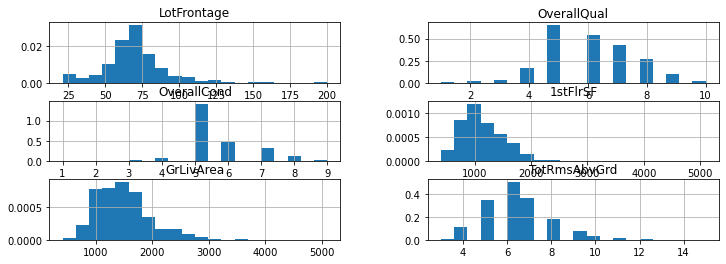

In [29]:
data[LogCandidates].hist(bins = 20,density = True,figsize =(12,4))

<p style="color:red">Does it make sense to change this, first scenario let's use the previous one.</p>

In [30]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to LotArea.

In [31]:
# note how we use the lambda that we learned from the train set
# in the notebook on Feature Engineering.

# Note that we need to hard code this value

#data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=-12.55283001172003)

<p style="color:red">Again, this value is not existing in our model.</p>

### Binarize skewed variables

There were a few variables very skewed, we would transform those into binary variables.

In [32]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
] #Old skewed

ListOfSkewd = [var for var in skewed if var in data.columns]
ListOfSkewd
#data[skewed].hist(bins = 20,density = True,figsize =(12,4))

['ScreenPorch']

array([[<AxesSubplot:title={'center':'ScreenPorch'}>]], dtype=object)

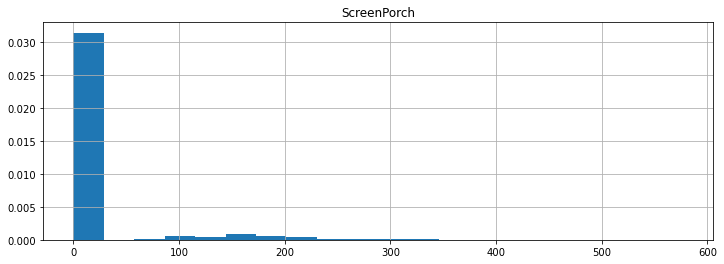

In [33]:
data[ListOfSkewd].hist(bins = 20,density = True,figsize =(12,4))

In [34]:
for var in ListOfSkewd:
    
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

## Categorical variables

### Apply mappings

We remap variables with specific meanings into a numerical scale.

In [35]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]
ListOfQual = [var for var in qual_vars if var in data.columns]
ListOfQual

['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu']

In [36]:
for var in ListOfQual:
    data[var] = data[var].map(qual_mappings)

In [37]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'
if var in data.columns:
    data[var] = data[var].map(exposure_mappings)

In [38]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

ListOfFinish = [var for var in finish_vars if var in data.columns]
ListOfFinish

['BsmtFinType1']

In [39]:
for var in ListOfFinish:
    data[var] = data[var].map(finish_mappings)

In [40]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'
if var in data.columns:
    data[var] = data[var].map(garage_mappings)

In [41]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'
if var in data.columns:
    data[var] = data[var].map(fence_mappings)

In [42]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

with_null

[]

**Surprise**

There are quite a few variables with missing data!!

<p style="color:red">Already predicted..</p>

In [43]:
# did those have missing data in the train set?

[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

**IMPORTANT**

In the new data, we have a bunch of variables that contain missing information, that we did not anticipate.

In [44]:
#Check again remaning cat values:
CatValues_2 = [var for var in data.columns if data[var].dtypes == 'O']
print(f'Number of cat values after first cleaning: {len(CatValues_2)}, previously: {len(CatValues)}')

Number of cat values after first cleaning: 13, previously: 21


In [45]:
CatValues_2

['MSSubClass',
 'MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'RoofStyle',
 'Exterior1st',
 'Foundation',
 'CentralAir',
 'Functional',
 'PavedDrive',
 'SaleCondition']

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations into a "Rare" string.

In [46]:
import copy 

MyDeepCOpy = copy.deepcopy(data)

In [47]:
MyDeepCOpy.head()

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Neighborhood,OverallQual,OverallCond,YearRemodAdd,...,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,ScreenPorch,SaleCondition
0,20,RH,4.382027,Reg,Lvl,Inside,NAmes,5,6,49,...,Typ,0,0,1,1.0,730.0,Y,140,1,Normal
1,20,RL,4.394449,IR1,Lvl,Corner,NAmes,6,6,52,...,Typ,0,0,1,1.0,312.0,Y,393,0,Normal
2,60,RL,4.304065,IR1,Lvl,Inside,Gilbert,5,5,12,...,Typ,1,3,3,2.0,482.0,Y,212,0,Normal
3,60,RL,4.356709,IR1,Lvl,Inside,Gilbert,6,6,12,...,Typ,1,4,3,2.0,470.0,Y,360,0,Normal
4,120,RL,3.761200,IR1,HLS,Inside,StoneBr,8,5,18,...,Typ,0,0,2,2.0,506.0,Y,0,1,Normal


In [48]:
# create a dictionary with the most frequent categories per variable

# note the amount of hard coding that I need to do.

# Can you think of an alternative? Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need

frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [49]:
set(data['PavedDrive'])

{'N', 'P', 'Y'}

In [50]:
np.where(data['PavedDrive'].isin(set(data['PavedDrive'])), data['PavedDrive'], 'Rare')

array(['Y', 'Y', 'Y', ..., 'Y', 'Y', 'Y'], dtype=object)

In [51]:
for var in frequent_ls.keys():
    if var in CatValues_2:
        #print('Var',var)
        # replace rare categories by the string "Rare"
        data[var] = np.where(data[var].isin(frequent_ls[var]), data[var], 'Rare')

<p style="color:red">Wrong code in example:</p>

for var in frequent_ls.keys():
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

<p style="color:red">This is not replacing values</p>

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 

In [52]:
# we need the mappings learned from the train set. Otherwise, our model is going
# to produce inaccurate results

# note the amount of hard coding that we need to do.

# Can you think of an alternative? 

# Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need

ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [53]:
for var in ordinal_mappings.keys():
    if var in CatValues_2:
        # use the dictionary to replace the categorical strings by integers
        data[var] = data[var].map(ordinal_mappings[var])

In [54]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

0

In [55]:
# there is missing data in a lot of the variables.

# unfortunately, the scaler wil not work with missing data, so
# we need to fill those values

# in the real world, we would try to understand where they are coming from
# and why they were not present in the training set

# here I will just fill them in quickly to proceed with the demo

data.fillna(0, inplace=True)

<p style="color:red">Not my case</p>

In [56]:
data

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Neighborhood,OverallQual,OverallCond,YearRemodAdd,...,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,ScreenPorch,SaleCondition
0,1,2,4.382027,0,1,0,8,5,6,49,...,4,0,0,1,1.0,730.0,2,140,1,3
1,1,3,4.394449,1,1,2,8,6,6,52,...,4,0,0,1,1.0,312.0,2,393,0,3
2,1,3,4.304065,1,1,0,13,5,5,12,...,4,1,3,3,2.0,482.0,2,212,0,3
3,1,3,4.356709,1,1,0,13,6,6,12,...,4,1,4,3,2.0,470.0,2,360,0,3
4,1,3,3.761200,1,3,0,20,8,5,18,...,4,0,0,2,2.0,506.0,2,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1,1,3.044522,0,1,0,1,4,7,36,...,4,0,0,1,0.0,0.0,2,0,0,3
1455,1,1,3.044522,0,1,0,1,4,5,36,...,4,0,0,1,1.0,286.0,2,0,0,1
1456,1,3,5.075174,0,1,0,9,5,7,10,...,4,1,3,1,2.0,576.0,2,474,0,1
1457,1,3,4.127134,0,1,0,9,5,5,14,...,4,0,0,1,0.0,0.0,2,80,0,3


## Feature Scaling

We will scale features to the minimum and maximum values:

In [57]:
#scaler
#I will create my own scaler

In [58]:
#Define new scaler
#Creating scaler
MyOwnScaler = MinMaxScaler()
#Fitting scaler into the data
MyOwnScaler.fit(data)

MinMaxScaler()

In [59]:
data = pd.DataFrame(
    MyOwnScaler.transform(data),
    columns=data.columns
)

In [60]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotShape,LandContour,LotConfig,Neighborhood,OverallQual,OverallCond,YearRemodAdd,...,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,ScreenPorch,SaleCondition
0,0.0,0.50,0.593445,0.000000,0.333333,0.0,0.363636,0.444444,0.625,0.822581,...,1.0,0.00,0.0,0.0,0.2,0.490591,1.0,0.098315,1.0,0.75
1,0.0,0.75,0.598957,0.333333,0.333333,0.5,0.363636,0.555556,0.625,0.870968,...,1.0,0.00,0.0,0.0,0.2,0.209677,1.0,0.275983,0.0,0.75
2,0.0,0.75,0.558854,0.333333,0.333333,0.0,0.590909,0.444444,0.500,0.225806,...,1.0,0.25,0.6,1.0,0.4,0.323925,1.0,0.148876,0.0,0.75
3,0.0,0.75,0.582212,0.333333,0.333333,0.0,0.590909,0.555556,0.625,0.225806,...,1.0,0.25,0.8,1.0,0.4,0.315860,1.0,0.252809,0.0,0.75
4,0.0,0.75,0.317987,0.333333,1.000000,0.0,0.909091,0.777778,0.500,0.322581,...,1.0,0.00,0.0,0.5,0.4,0.340054,1.0,0.000000,1.0,0.75


In [61]:
# load the pre-selected features
# ==============================

features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

# reduce the train and test set to the selected features
data = data[features]

data.shape

(1459, 36)

<p style="color:red">This should be done at the very beginning</p>

Note that we engineered so many variables, when we are actually going to feed only 31 to the model.

**What could we do differently?**

We could have, of course, engineered only the variables that we are going to use in the model. But that means:

- identifying which variables we need
- identifying which transformation we need per variable
- redefining our dictionaries accordingly
- retraining the MinMaxScaler only on the selected variables (at the moment, it is trained on the entire dataset)

That means, that we need to create extra code to train the scaler only on the selected variables. Probably removing the scaler from the Feature Engineering notebook and passing it onto the Feature Selection one.

We need to be really careful in re-writing the code here to make sure we do not forget or engineer wrongly any of the variables.

In [304]:
data.shape

(1459, 36)

<AxesSubplot:>

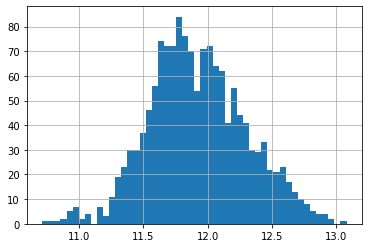

In [62]:
lin_model = joblib.load('linear_regression.joblib') 

# let's obtain the predictions
pred = lin_model.predict(data)

# let's plot the predicted sale prices
pd.Series(pred).hist(bins=50)

<AxesSubplot:>

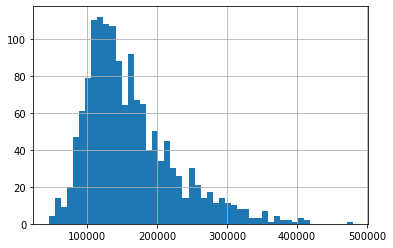

In [64]:
lin_model = joblib.load('linear_regression.joblib') 

# let's obtain the predictions
pred = lin_model.predict(data)

# let's plot the predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50)

In [309]:
features.remove('YrSold')

In [ ]:
#MyOutput

<AxesSubplot:>

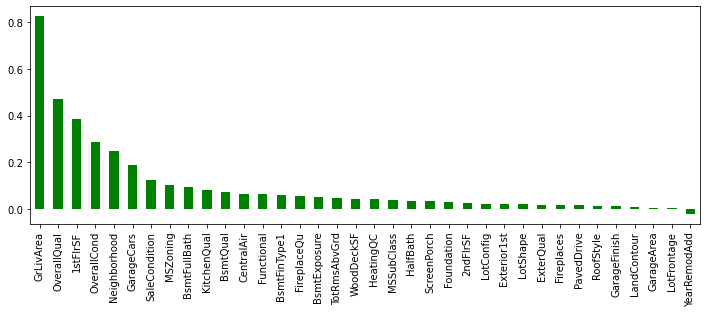

In [307]:
Imp = pd.Series(lin_model.coef_.ravel())
Imp.index = features
Imp.sort_values(inplace = True, ascending = False)
Imp.plot.bar(figsize = (12,4),color = 'green')

What shortcomings, inconvenience and problems did you find when scoring new data?

# List of problems

- re-wrote a lot of code ==> repetitive
- hard coded a lot of parameters ==> if these change we need to re-write them again
- engineered a lot of variables that we actually do not need for the model
- additional variables present missing data, we do not know what to do with them

We can minimize these hurdles by using Open-source. And we will see how in the next videos.